# Drinkwaterwinning Bleijerheide

## Inladen Python pakketten

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

De dataset is opgesplitst in 3 perioden:
- de trainings-set: van 1 juli 2023 t/m 30 november. Wordt gebruikt om de parameters aan te passen;
- de validatie-set: van 1 december 2023 t/m 31 januari 2024. Wordt gebruikt om de kwaliteit van het model continue te beoordelen om 'overfitting' te voorkomen - op een bepaald moment als de het model voor de trainingsset beter wordt, wordt de kwaliteit voor de validatieset weer minder (dan vindt 'over-fitting' plaats). Op dat moment wordt de training gestopt;
- de test-set: een onafhankelijke periode waarop het model wordt toegepast. Door gebrek aan betrouwbare data overlapt die nu met de validatie.

Het getrainde model laden we in uit de bestanden:

In [2]:
model = tf.keras.models.load_model('./model')

## Resultaten test-periode

X_test is de afvoer van verhard gebied en dakoppervlak die is voorbewerkt.
Dit is de invoerdata voor het model.

Y_test is de bijbehorende neerslag (geen invoer, maar validatie).

In [7]:
X_test = pd.read_csv('data/X_test_scaled_new.csv', index_col=0, parse_dates=True)
Y_test = pd.read_csv('data/Y_test_new.csv', index_col=0, parse_dates=True)

We stoppen X_test in het model en daarkomt dan een gesimuleerde neerslag uit, y_hat:

In [8]:
y_hat = pd.DataFrame(index=X_test.index, data=model.predict(X_test), columns=['P_pred'])
# soms zijn waarden heel licht 0
y_hat[y_hat['P_pred'] < 0.] = 0.

13/13 [==============================] - 0s 1ms/step


In [19]:
def plot_resultaat(observation, prediction, path=None, title=None):
    Path(path).parents[0].mkdir(exist_ok=True, parents=False)
    fig, ax = plt.subplots(1,1,figsize=(14,4))
    ax.plot(prediction.index, prediction['P_pred'], 'orange', linestyle='-', zorder=1, label='P_pred')
    ax.plot(observation.index, observation['P'], zorder=0, label='P')
    plt.xlabel('Datum')
    plt.legend()
    plt.grid(True)
    ax.set_xlim(prediction.index[0], prediction.index[-1])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(title)
    plt.savefig(path, dpi=100, transparent=False)
    

We plotten zowel de gemeten als de voorspelde neerslag...

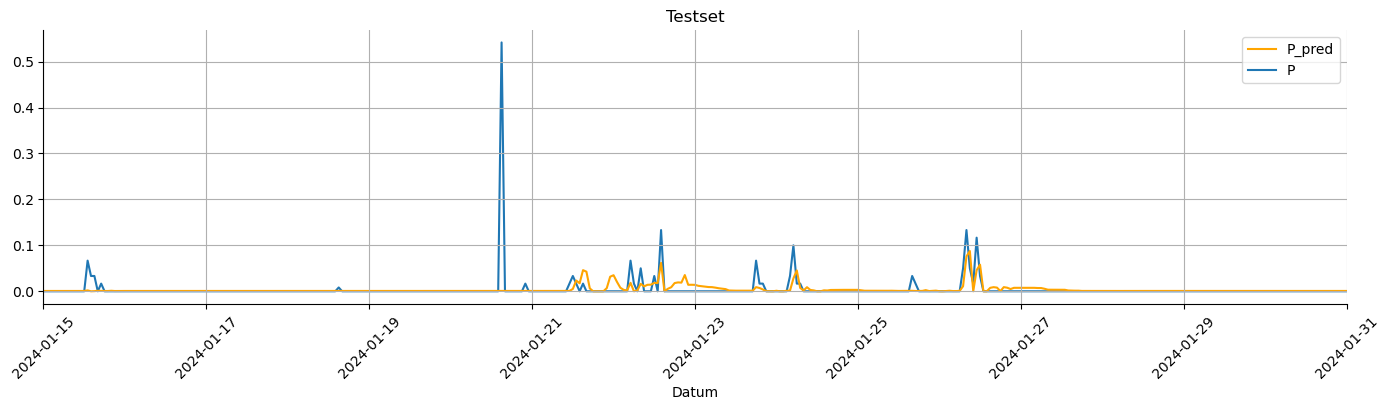

In [20]:
plot_resultaat(Y_test, y_hat, path='figuren_model/resultaat_testset.png', title='Testset')

... en schrijven ook het resultaat naar csv.

In [21]:
output = pd.concat([y_hat, Y_test], axis=1, ignore_index=False)
Path('tabellen_model').mkdir(parents=False, exist_ok=True)
output.to_csv(r'tabellen_model/resultaat_testperiode.csv', sep=",")

In deze periode blijkt een neerslagpiek te zijn geweest die geen relatie heeft met de afvoer - het model kan deze dus ook niet voorspellen. 

## Resultaten validatieperiode

Nu doen we hetzeldfde met de validatieperiode:

35/35 [==============================] - 0s 946us/step


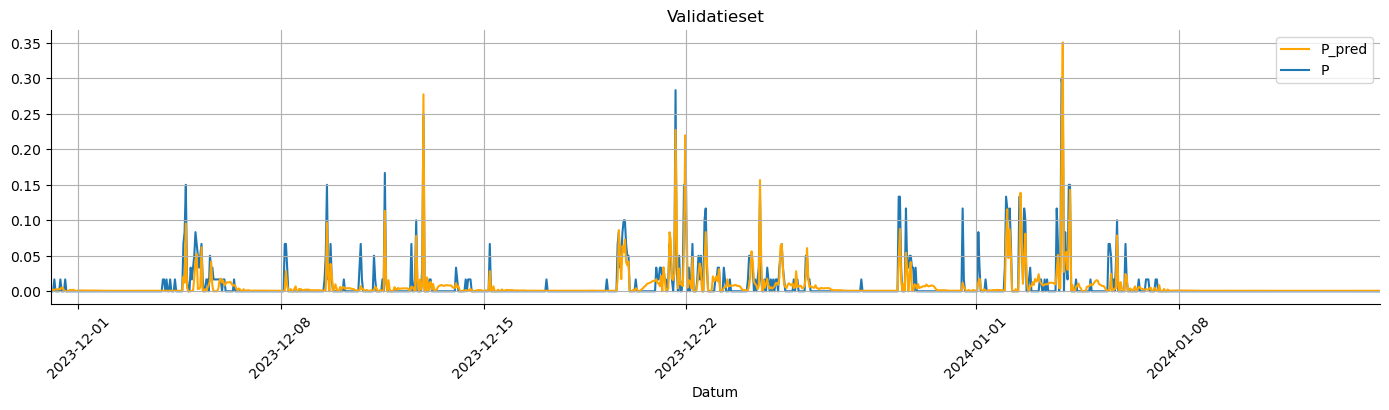

In [23]:
# inladen features
X_val = pd.read_csv('data/X_val_scaled_new.csv', index_col=0, parse_dates=True)

# inladen target
Y_val = pd.read_csv('data/Y_val_new.csv', index_col=0, parse_dates=True)

# maak voorspelling
y_val_hat = pd.DataFrame(index=X_val.index, data=model.predict(X_val), columns=['P_pred'])
y_val_hat[y_val_hat['P_pred'] < 0] = 0

# plot 
plot_resultaat(Y_val, y_val_hat, path='figuren_model/resultaat_validatieset.png', title="Validatieset")

In [25]:
output = pd.concat([y_val_hat, Y_val_test], axis=1, ignore_index=False)
Path('tabellen_model').mkdir(parents=False, exist_ok=True)
output.to_csv(r'tabellen_model/resultaat_validatieperiode.csv', sep=",")

NameError: name 'Y_val_test' is not defined

### Selectie met start- en einddatum

In [ ]:
def select_daterange(df, start_date, end_date):
    """
    Returns a DataFrame with only the rows between the start and end date.
    """
    mask = (df.index >= start_date) & (df.index < end_date)
    df_selected = df.loc[mask]
    return df_selected

In [ ]:
# kies startdatum 
start_date = pd.to_datetime('2023-12-22')

# kies einddatum
end_date = pd.to_datetime('2024-01-08')

plot_resultaat(select_daterange(Y_val, start_date, end_date), select_daterange(y_val_hat, start_date, end_date), path='figuren_model/resultaat_validatieset.png', title="Validatieset")